In [16]:
%cd examples/
%load_ext autoreload
%autoreload 2

[Errno 2] No such file or directory: 'examples/'
/home/vmu/nu_stats/examples
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
from astropy import units as u
from matplotlib import pyplot as plt
import numpy as np

In [18]:
import sys
sys.path.append("../")
from nu_stats.simulation import Simulation


In [19]:
# Simulation parameters
L = 1e48 * (u.erg/u.s)
gamma = 2.2
z = 0.3
F_diff_norm = 1e-15 * 1/(u.GeV * u.cm**2 * u.s)
Emin = 1e5 * u.GeV
Emax = 1e8 * u.GeV
Enorm = 1e5 * u.GeV

In [20]:
Nsims = 100
sims=[Simulation(L, gamma, z, F_diff_norm = F_diff_norm,
    Emin=Emin, Emax=Emax, Enorm=Enorm) for i in range(Nsims)]

In [21]:
for i in range(Nsims):
    sims[i].run(seed=np.random.randint(10000000),verbose=False)
    if i>0:
        assert sims[i].truth == sims[i-1].truth
fit_inputs = [sim.get_data() for sim in sims]

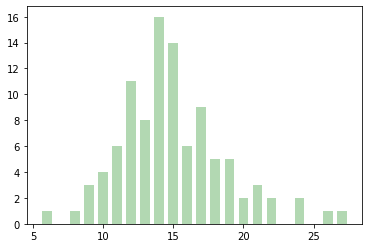

In [22]:
truenss = [sum(sim.labels==0) for sim in sims]
plt.hist(truenss, bins=np.arange(min(truenss)-1,max(truenss)+1)+.5,
    color='g', alpha = .3, histtype='barstacked', rwidth = 0.7);

In [23]:
from nu_stats.fqutils import FqStructure
from nu_stats.bhmutils import BhStructure

In [24]:
fqs = [FqStructure(fit_input=f_i) for f_i in fit_inputs]
nhs = []
ghs = []
for i in range(Nsims):
    fqs[i].construct_diffuse_bg_energy_likelihood(
        fit_inputs[i]['z_bg'], Emin, Emax, min_index=1.5, max_index=4.0, n_Esim=100000,
        Nbins=25, prefab_likelihood_file='tmp/False1.0_25lik.npy', verbose= False
    )
    fqs[i].construct_source_energy_likelihood(
        fit_inputs[i]['z'], Emin, Emax, min_index=1.5, max_index=4.0, n_Esim=100000,
        Nbins=25, prefab_likelihood_file='tmp/True0.3_25lik.npy', verbose= False
    )
    _, nh, gh = fqs[i].minimize_neg_lbl()
    nhs.append(nh)
    ghs.append(gh)

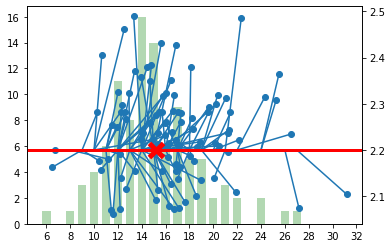

In [25]:
fig, axh = plt.subplots()

axh.hist(truenss, bins=np.arange(min(truenss)-1,max(truenss)+1)+.5,
    color='g', alpha = .3, histtype='barstacked', rwidth = 0.7, zorder = -20)

ax = axh.twinx()
for i in range(Nsims):
    plt.plot([nhs[i], truenss[i]], [ghs[i], gamma],c='C0', zorder=-10)
plt.scatter(nhs,ghs)
plt.scatter(sims[0].Nex_ps, gamma, s=200 , marker='x', c='r', linewidths=5,
    label = r'True $(\bar{N}_s,\gamma)$')
ax.axhline(gamma, c='r', linewidth = 3)

plt.xticks(np.arange(np.floor(min(nhs)),
                     np.ceil(max(nhs)+1),
                     2))
fig.show()

In [11]:
bhms = [BhStructure(f_i) for f_i in fit_inputs]

for i in range(Nsims):
    bhms[i].load_model("stan/toy_bhm.stan")
    bhms[i].run(seed=np.random.randint(10000000))

NFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /home/vmu/nu_stats/examples/bayes_hierarchical_model/stan/toy_bhm
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /home/vmu/nu_stats/examples/bayes_hierarchical_model/stan/toy_bhm
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /home/vmu/nu_stats/examples/bayes_hierarchical_model/stan/toy_bhm
INFO

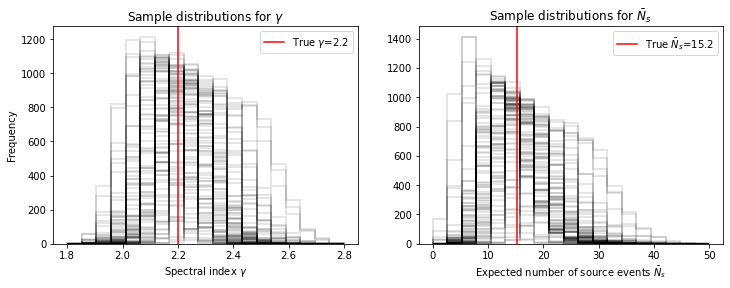

In [16]:
fig, ax = plt.subplots(1,2)
for i in range(Nsims):
    if min(bhms[i].fit.stan_variable('gamma'))<1.5:
        continue
    ax[0].hist(bhms[i].fit.stan_variable('gamma'),
        bins=np.linspace(1.8, 2.8, 20),
        histtype = 'step',
        linewidth = 2,
        alpha = 0.1,
        color = 'k')

    ax[1].hist(bhms[i].fit.stan_variable('Nex_ps'),
        bins=np.linspace(0, 50, 20),
        histtype = 'step',
        linewidth = 2,
        alpha = 0.1,
        color = 'k')

ax[0].axvline(gamma,
    label=r'True $\gamma$'+f'={gamma:.3}',
    c='r')
ax[0].legend()
ax[0].set_xlabel('Spectral index $\gamma$')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Sample distributions for $\gamma$')
ax[1].axvline(sims[0].Nex_ps,
    label=r'True $\bar{N}_s$'+f'={sims[0].Nex_ps:.3}',
    c='r')
ax[1].legend()
ax[1].set_xlabel(r'Expected number of source events $\bar{N}_s$')
ax[1].set_title(r'Sample distributions for $\bar{N}_s$')

fig.set_size_inches((fig.get_size_inches()[0]*2,fig.get_size_inches()[1]))
fig.show()

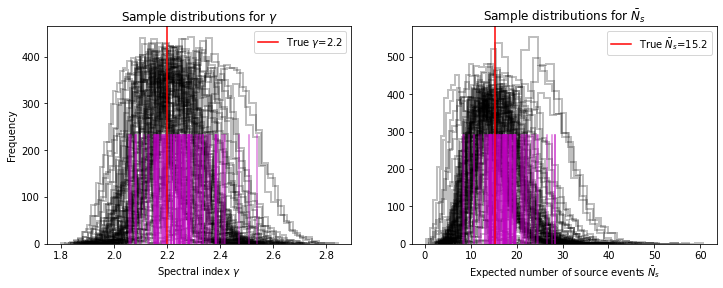

In [17]:
fig, ax = plt.subplots(1,2)
for i in range(Nsims):
    if min(bhms[i].fit.stan_variable('gamma'))<1.5:
        continue
    ax[0].hist(bhms[i].fit.stan_variable('gamma'),
        bins=30,
        histtype = 'step',
        linewidth = 2,
        alpha = 0.25,
        color = 'k')
    ax[0].axvline(ghs[i],0,.5, c='m', alpha = .5)

    ax[1].hist(bhms[i].fit.stan_variable('Nex_ps'),
        bins=30,
        histtype = 'step',
        linewidth = 2,
        alpha = 0.25,
        color = 'k')
    ax[1].axvline(nhs[i],0,.5, c='m', alpha = .5)

ax[0].axvline(gamma,
    label=r'True $\gamma$'+f'={gamma:.3}',
    c='r')
ax[0].legend()
ax[0].set_xlabel('Spectral index $\gamma$')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Sample distributions for $\gamma$')
ax[1].axvline(sims[0].Nex_ps,
    label=r'True $\bar{N}_s$'+f'={sims[0].Nex_ps:.3}',
    c='r')
ax[1].legend()
ax[1].set_xlabel(r'Expected number of source events $\bar{N}_s$')
ax[1].set_title(r'Sample distributions for $\bar{N}_s$')

fig.set_size_inches((fig.get_size_inches()[0]*2,fig.get_size_inches()[1]))
fig.show()

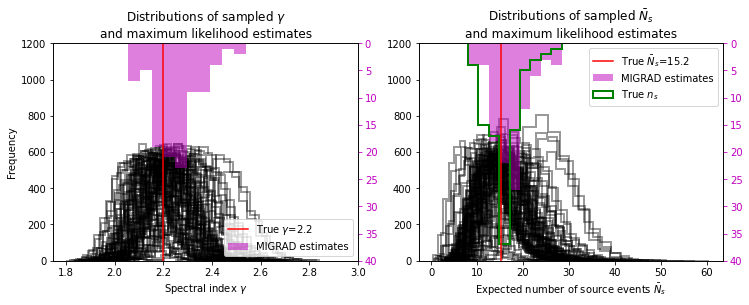

In [18]:
fig, ax = plt.subplots(1,2)
for i in range(Nsims):
    if min(bhms[i].fit.stan_variable('gamma'))<1.5:
        continue
    ax[0].hist(bhms[i].fit.stan_variable('gamma'),
        bins=20,
        histtype = 'step',
        linewidth = 2,
        alpha = 0.4,
        color = 'k')

    ax[1].hist(bhms[i].fit.stan_variable('Nex_ps'),
        bins=20,
        histtype = 'step',
        linewidth = 2,
        alpha = 0.4,
        color = 'k')

ax[0].set_xlabel('Spectral index $\gamma$')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Distributions of sampled $\gamma$\nand maximum likelihood estimates')
ax[0].set_ylim(0,1200)
ax[0].set_xlim(ax[0].get_xlim()[0],3.0)

axh0 = ax[0].twinx()
axh0.tick_params(axis='y', colors='m')
axh0.hist(ghs, bins=10, color = 'm', alpha = .5, label='MIGRAD estimates')#,histtype='step', linewidth=2)
axh0.set_ylim(0,40)
axh0.invert_yaxis()
axh0.axvline(gamma,
    label=r'True $\gamma$'+f'={gamma:.3}',
    c='r')
axh0.legend()

ax[1].set_xlabel(r'Expected number of source events $\bar{N}_s$')
ax[1].set_title(r'Distributions of sampled $\bar{N}_s$'+'\nand maximum likelihood estimates')
ax[1].set_ylim(0,1200)

axh1 = ax[1].twinx()
nsbins = np.linspace(min(min(nhs),min(truenss)),
    max(max(nhs),max(truenss)),
    10
)
axh1.axvline(sims[0].Nex_ps,
    label=r'True $\bar{N}_s$'+f'={sims[0].Nex_ps:.3}',
    c='r')
_,b,_ = axh1.hist(nhs, bins=nsbins, color='m', alpha = .5, label='MIGRAD estimates')#, histtype='step', linewidth=2)
axh1.hist(truenss, bins=nsbins, color='g', label='True $n_s$', histtype='step', linewidth=2)
axh1.tick_params(axis='y', colors='m')
axh1.set_ylim(0,40)
axh1.invert_yaxis()
axh1.legend()

fig.set_size_inches((fig.get_size_inches()[0]*2,fig.get_size_inches()[1]))
fig.show()